# Blocking Variance Test

In [274]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
!pip install progressbar2
import progressbar
from parla.utils.sketching import sjlt_operator

# These test the ACCURACY of the sketch clustering theory

# First sketch: select i.i.d. a constant # within each column

data_matrix_height_width_ratio = 100
data_matrix_width = 100
data_matrix_height = data_matrix_height_width_ratio * data_matrix_width
sketch_height = int(data_matrix_width * 2.0)

#X = np.random.rand(data_matrix_height, data_matrix_width)
X = np.tile(np.eye(data_matrix_width), data_matrix_height_width_ratio).T
rows = np.random.randint(low=0, high=X.shape[0], size=X.shape[1])

X[rows, :] *= 1e4

def sketchSklearn(mat, nnz_per_column, output_dim):
    density = nnz_per_column / output_dim
    proj = SparseRandomProjection(n_components=output_dim, density=density)
    return proj.fit_transform(mat.T).T

def sketchParla(mat, nnz_per_column, output_dim):
    sparse_op = sjlt_operator(output_dim, mat.shape[0], np.random.randint(0, 10000), vec_nnz=nnz_per_column)
    return sparse_op @ mat



Defaulting to user installation because normal site-packages is not writeable


In [264]:
# Condition number of A_pre = A inv(R)
# Where R is the triangular factor from QR of S@A.

def conditionNumber(A, Ahat):
    q, r = la.qr(Ahat, mode='economic')
    A_pre = la.solve_triangular(r, A.T, trans='T').T
    sigma = la.svd(A_pre, compute_uv=False)
    return sigma[0] / sigma[-1]

#Distortion
#smallest \eta so that (1 - \eta)|| A x || <= || S A x|| <= (1 + \eta) || A x || 
# for all x in R^n

# A distortion of eta ---> the error from preconditioned normal equations decays by
# a factor eta at every step of a subsequent iterative LSQ method, such as CGLS

# Compute eta via bisection, as long as we can verify condition for a single value of eta

# (S A)' (S A) - (1 - \eta)^2 A'A
# and
# (1 + \eta)^2 A'A - (SA)'(SA)
# need to be positive semidefinite

def computeDistortion(A, Ahat, tol=0.005):
    etaMin = 0
    etaMax = 1
    
    sketched = Ahat.T @ Ahat
    original = A.T @ A
    
    while etaMax - etaMin > tol: 
        bothPSD = True
        eta = (etaMin + etaMax) / 2
        try:
            la.cholesky(sketched - (1 - eta) ** 2 * original)
            la.cholesky((1 + eta) ** 2 * original - sketched)
            pass
        except np.linalg.LinAlgError:
            bothPSD = False
            
        if bothPSD:
            etaMax = eta
        else:
            etaMin = eta
        
    return (etaMin + etaMax) / 2


In [275]:
nnz_test = [1, 3, 5, 7, 9, 11, 13]
meanCondition = []
stdCondition = []
meanDistortion = []
stdDistortion = []

for nnz in nnz_test:
    conditionNumbers = []
    distortionFactors = []
    for i in progressbar.progressbar(range(100)):
        Xhat = sketchParla(X, nnz, sketch_height)
        conditionNumbers.append(conditionNumber(X, Xhat))
        distortionFactors.append(computeDistortion(X, Xhat))
    
    meanCondition.append(np.mean(conditionNumbers))
    stdCondition.append(np.std(conditionNumbers))
    
    meanDistortion.append(np.mean(distortionFactors))
    stdDistortion.append(np.std(distortionFactors))
    

100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (100 of 100) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


In [276]:
nnz_test = [1, 3, 5, 7, 9, 11, 13]
meanConditionRegular = []
stdConditionRegular = []
meanDistortionRegular = []
stdDistortionRegular = []

Xreg = np.random.rand(X.shape[0], X.shape[1]) * 1e4

for nnz in nnz_test:
    conditionNumbers = []
    distortionFactors = []
    for i in progressbar.progressbar(range(100)):
        Xhat = sketchParla(Xreg, nnz, sketch_height)
        conditionNumbers.append(conditionNumber(Xreg, Xhat))
        distortionFactors.append(computeDistortion(Xreg, Xhat))
    
    meanConditionRegular.append(np.mean(conditionNumbers))
    stdConditionRegular.append(np.std(conditionNumbers))
    
    meanDistortionRegular.append(np.mean(distortionFactors))
    stdDistortionRegular.append(np.std(distortionFactors))

100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25


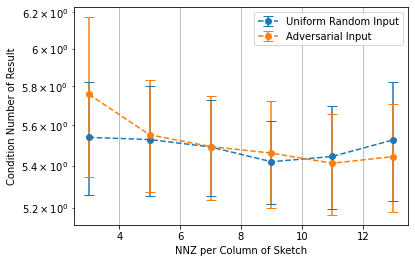

In [280]:
plt.errorbar(nnz_test[1:], meanConditionRegular[1:], np.array(stdConditionRegular)[1:], capsize=5, label="Uniform Random Input",fmt='--o')
plt.errorbar(nnz_test[1:], meanCondition[1:], np.array(stdCondition)[1:], capsize=5, label="Adversarial Input", fmt='--o')
plt.xlabel("NNZ per Column of Sketch")
plt.ylabel("Condition Number of Result")
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.savefig("riley_img/condition_number.pdf")

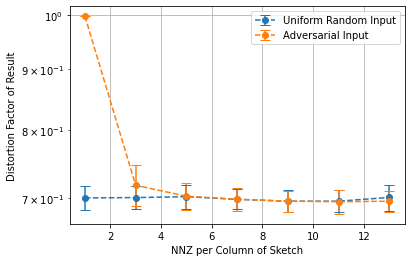

In [282]:
plt.errorbar(nnz_test, meanDistortionRegular, np.array(stdDistortionRegular), capsize=5, label="Uniform Random Input", fmt='--o')
plt.errorbar(nnz_test, meanDistortion, np.array(stdDistortion), capsize=5, label="Adversarial Input", fmt='--o')
#plt.yscale('log')
plt.xlabel("NNZ per Column of Sketch")
plt.ylabel("Distortion Factor of Result")
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.savefig("riley_img/distortion_factor.pdf")